In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset


In [14]:
# Load annotations
file_path = 'data\EN\subtask-2-annotations.txt'
df = pd.read_csv(file_path, sep="\t", header=None, names=["Document_ID", "High_Level_Narratives", "Sub_Narratives"])

# Group by Document_ID and aggregate narratives
df = df.groupby("Document_ID").agg({
    "High_Level_Narratives": lambda x: list(set(";".join(x).split(";"))),
    "Sub_Narratives": lambda x: list(set(";".join(x).split(";")))
}).reset_index()

# Print basic information
print("Total number of documents:", len(df))
print("\nSample of the data:")
df['High_Level_Narratives'][0]

Total number of documents: 399

Sample of the data:


['CC: Controversy about green technologies',
 'CC: Criticism of institutions and authorities',
 'CC: Hidden plots by secret schemes of powerful groups']

In [6]:
# Function to check if a narrative list contains only "Other"
def is_other(narratives):
    return all(narrative.strip() == "Other" for narrative in narratives)

# Function to determine if document is URW (1) or CC (0)
def get_domain_label(narratives):
    has_urw = any("URW:" in narrative for narrative in narratives)
    has_cc = any("CC:" in narrative for narrative in narratives)

    if has_urw and not has_cc:
        return 1  # URW
    elif has_cc and not has_urw:
        return 0  # CC
    else:
        return None  # This shouldn't happen in our filtered dataset

# Filter out "Other" documents and create binary labels
df_filtered = df[~df['High_Level_Narratives'].apply(is_other)].copy()
df_filtered['label'] = df_filtered['High_Level_Narratives'].apply(get_domain_label)

# Print statistics
print("Total documents after filtering:", len(df_filtered))
print("\nLabel distribution:")
print(df_filtered['label'].value_counts())
print("\nSample of processed data:")
print(df_filtered[['Document_ID', 'label']].head())

Total documents after filtering: 230

Label distribution:
label
1.0    127
0.0    102
Name: count, dtype: int64

Sample of processed data:
        Document_ID  label
0  EN_CC_100000.txt    0.0
1  EN_CC_100002.txt    0.0
2  EN_CC_100003.txt    0.0
3  EN_CC_100004.txt    0.0
4  EN_CC_100005.txt    0.0


In [7]:
import os

# Path to raw documents
raw_docs_path = '/content/files/EN/raw-documents'

# Function to load document text
def load_document_text(doc_id, folder_path):
    file_path = os.path.join(folder_path, doc_id)
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read().strip()
    except Exception as e:
        print(f"Error reading {doc_id}: {e}")
        return None

# Load text content for filtered documents
df_filtered['text'] = df_filtered['Document_ID'].apply(lambda x: load_document_text(x, raw_docs_path))

# Remove any entries where text loading failed
df_filtered = df_filtered.dropna(subset=['text'])

# Print statistics
print("Documents with successfully loaded text:", len(df_filtered))
print("\nSample text length distribution:")
print(df_filtered['text'].str.len().describe())
print("\nFirst few characters of first document:")
print(df_filtered['text'].iloc[0][:200] + "...")

Documents with successfully loaded text: 230

Sample text length distribution:
count     230.000000
mean     3042.082609
std       871.394168
min       958.000000
25%      2385.000000
50%      3022.000000
75%      3607.500000
max      5602.000000
Name: text, dtype: float64

First few characters of first document:
Pentagon plans to serve LAB-GROWN MEAT to troops in the name of climate change 

 The Washington Free Beacon reported that BioMADE, a public-private partnership that has received more than $500 millio...


In [8]:
# Load original data again to check
original_df = pd.read_csv('/content/files/EN/subtask-2-annotations.txt', sep="\t", header=None,
                         names=["Document_ID", "High_Level_Narratives", "Sub_Narratives"])

# Group by Document_ID
grouped_original = original_df.groupby("Document_ID").agg({
    "High_Level_Narratives": lambda x: list(x)
}).reset_index()

# Count documents where all narratives are "Other"
def is_all_other(narratives):
    return all(narrative.strip() == "Other" for narrative in narratives)

others_count = grouped_original[grouped_original['High_Level_Narratives'].apply(is_all_other)].shape[0]
non_others_count = grouped_original[~grouped_original['High_Level_Narratives'].apply(is_all_other)].shape[0]

print(f"Total documents in original file: {len(grouped_original)}")
print(f"Documents labeled as 'Other': {others_count}")
print(f"Documents labeled as non-Other: {non_others_count}")
print(f"\nIn our filtered dataset: {len(df_filtered)}")
print("\nVerification:")
print(f"Non-Others match: {'Yes' if non_others_count == len(df_filtered) else 'No'}")

Total documents in original file: 399
Documents labeled as 'Other': 169
Documents labeled as non-Other: 230

In our filtered dataset: 230

Verification:
Non-Others match: Yes


In [9]:
# Initialize tokenizer
MODEL_NAME = "roberta-base"  # We can experiment with different models
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create HuggingFace dataset
dataset = Dataset.from_pandas(df_filtered[['text', 'label']])

# Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=512  # RoBERTa's maximum sequence length
    )

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Split into train and test sets
train_test = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

print("Dataset sizes:")
print(f"Training: {len(train_test['train'])}")
print(f"Testing: {len(train_test['test'])}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Dataset sizes:
Training: 184
Testing: 46


In [17]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2  # Binary classification: URW (1) vs CC (0)
)

# Check for NaN values and data types
print("Data checks:")
print("NaN values in labels:", df_filtered['label'].isna().sum())
print("Label value counts:")
print(df_filtered['label'].value_counts(dropna=False))
print("\nLabel dtype:", df_filtered['label'].dtype)

# Clean and convert labels
df_filtered = df_filtered.dropna(subset=['label'])  # Remove rows with NaN labels
df_filtered['label'] = df_filtered['label'].astype(int)

# Create dataset
dataset = Dataset.from_pandas(df_filtered[['text', 'label']])

# Tokenize the dataset
tokenized_dataset = dataset.map(
    lambda examples: tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=512
    ),
    batched=True
)

# Rename 'label' to 'labels'
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')

# Split into train and test sets
train_test = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

print("\nFinal dataset info:")
print(f"Training size: {len(train_test['train'])}")
print(f"Testing size: {len(train_test['test'])}")
print("\nSample of final labels:", train_test['train']['labels'][:5])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=["none"]
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=train_test['test'],
    compute_metrics=compute_metrics
)

print("\nModel and training configuration ready!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Data checks:
NaN values in labels: 1
Label value counts:
label
1.0    127
0.0    102
NaN      1
Name: count, dtype: int64

Label dtype: float64


<ipython-input-17-744f0d644743>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['label'].astype(int)


Map:   0%|          | 0/229 [00:00<?, ? examples/s]


Final dataset info:
Training size: 183
Testing size: 46

Sample of final labels: [0, 0, 0, 1, 1]


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Model and training configuration ready!


In [18]:
# Train the model
training_results = trainer.train()



print("\nTraining completed!")
print("\nFinal Metrics:")
print(training_results.metrics)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.716600,0.719671,0.434783,0.263505,0.189036,0.434783
2,0.729000,0.701243,0.434783,0.263505,0.189036,0.434783
3,0.679600,0.635140,0.913043,0.911318,0.924638,0.913043
4,0.310300,0.214332,0.913043,0.913373,0.927536,0.913043
5,0.014300,0.246392,0.956522,0.956522,0.956522,0.956522


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training completed!

Final Metrics:
{'train_runtime': 160.5744, 'train_samples_per_second': 5.698, 'train_steps_per_second': 0.716, 'total_flos': 240746615654400.0, 'train_loss': 0.5151111701260442, 'epoch': 5.0}


In [20]:
from torch.nn.functional import softmax
import torch

def predict_domain(text):
    # Check if CUDA is available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)  # Move model to the appropriate device

    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)

    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Move outputs to CPU for processing
    probs = softmax(outputs.logits, dim=1).cpu()
    prediction = torch.argmax(probs, dim=1).item()

    # Get confidence score
    confidence = probs[0][prediction].item()

    # Map prediction to label
    label = "URW" if prediction == 1 else "CC"

    return {
        'prediction': label,
        'confidence': confidence,
        'probabilities': {
            'CC': probs[0][0].item(),
            'URW': probs[0][1].item()
        }
    }

# Test on a few examples from our test set
print("Example predictions:")
for i in range(3):
    test_text = train_test['test'][i]['text']
    true_label = "URW" if train_test['test'][i]['labels'] == 1 else "CC"
    result = predict_domain(test_text[:1000])  # Using first 1000 chars for display

    print(f"\nExample {i+1}:")
    print(f"True label: {true_label}")
    print(f"Predicted: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Text preview: {test_text[:100]}...")

Example predictions:

Example 1:
True label: URW
Predicted: URW
Confidence: 99.78%
Text preview: Great Reset Currency Collapse! - Russia Has Gold Standard - Inflation Hits Record High! WAM 

 Great...

Example 2:
True label: URW
Predicted: URW
Confidence: 99.78%
Text preview: UN Chief Warns of Global Economic Crisis at World Economic Forum in Davos 

 United Nations Secretar...

Example 3:
True label: URW
Predicted: URW
Confidence: 99.79%
Text preview: Russia converting ordinary bombs into guided missiles, Kyiv media claims 

 Kyiv: Russia is adapting...


In [21]:
# Test examples with similar semantic structures
challenging_examples = [
    # URW example discussing economic impact
    """Global markets face uncertainty as sanctions impact energy prices.
    The ongoing conflict has led to increased oil prices, affecting European economies significantly.
    Analysts warn of potential recession risks as trading restrictions continue to influence international markets.
    Several countries are seeking alternative energy sources to reduce dependency.""",

    # CC example with similar economic/market language
    """Global markets react to new carbon pricing policies.
    The ongoing transition to renewable energy has led to increased electricity prices, affecting European economies significantly.
    Analysts warn of potential economic risks as emission restrictions continue to influence international markets.
    Several countries are seeking alternative energy sources to reduce emissions."""
]

print("Testing challenging examples:\n")
for i, text in enumerate(challenging_examples):
    result = predict_domain(text)

    print(f"\nExample {i+1}:")
    print(f"Expected: {'URW' if i == 0 else 'CC'}")
    print(f"Predicted: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probabilities: CC: {result['probabilities']['CC']:.2%}, URW: {result['probabilities']['URW']:.2%}")
    print(f"Text preview: {text[:100]}...")
    print("-" * 80)

Testing challenging examples:


Example 1:
Expected: URW
Predicted: URW
Confidence: 89.08%
Probabilities: CC: 10.92%, URW: 89.08%
Text preview: Global markets face uncertainty as sanctions impact energy prices. 
    The ongoing conflict has led...
--------------------------------------------------------------------------------

Example 2:
Expected: CC
Predicted: CC
Confidence: 99.66%
Probabilities: CC: 99.66%, URW: 0.34%
Text preview: Global markets react to new carbon pricing policies. 
    The ongoing transition to renewable energy...
--------------------------------------------------------------------------------


In [22]:
import os

# Create directory for saving
save_directory = './urw_cc_classifier'
os.makedirs(save_directory, exist_ok=True)

# Save model
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Model and tokenizer saved to:", save_directory)

Model and tokenizer saved to: ./urw_cc_classifier


In [23]:
class URWCCClassifier:
    def __init__(self, model_path='./urw_cc_classifier'):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

    def predict(self, text):
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True
        )

        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Get prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = softmax(outputs.logits, dim=1).cpu()
            prediction = torch.argmax(probs, dim=1).item()

        # Get confidence and label
        confidence = probs[0][prediction].item()
        label = "URW" if prediction == 1 else "CC"

        return {
            'prediction': label,
            'confidence': confidence,
            'probabilities': {
                'CC': probs[0][0].item(),
                'URW': probs[0][1].item()
            },
            'text_preview': text[:100] + "..."
        }

# Initialize classifier
classifier = URWCCClassifier()
print("Classifier initialized and ready for predictions!")

Classifier initialized and ready for predictions!


In [24]:
# Cell 3: Example usage
def process_new_text(text):
    result = classifier.predict(text)
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probabilities:")
    print(f"  CC: {result['probabilities']['CC']:.2%}")
    print(f"  URW: {result['probabilities']['URW']:.2%}")
    print(f"Text preview: {result['text_preview']}")
    return result

# Test with a new example
new_text = """The impact of rising temperatures on agricultural yields has become increasingly concerning..."""
print("Testing new example:\n")
process_new_text(new_text)

Testing new example:

Prediction: CC
Confidence: 99.61%
Probabilities:
  CC: 99.61%
  URW: 0.39%
Text preview: The impact of rising temperatures on agricultural yields has become increasingly concerning......


{'prediction': 'CC',
 'confidence': 0.9960736036300659,
 'probabilities': {'CC': 0.9960736036300659, 'URW': 0.003926432691514492},
 'text_preview': 'The impact of rising temperatures on agricultural yields has become increasingly concerning......'}

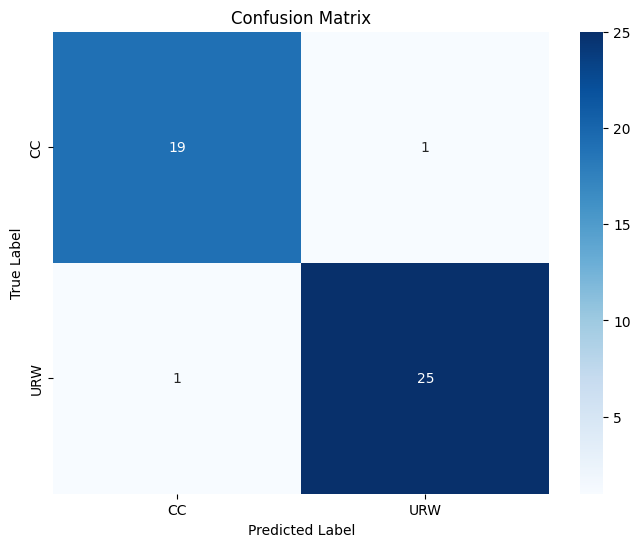

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix():
    # Get predictions for test set
    predictions = []
    true_labels = []

    for item in train_test['test']:
        result = classifier.predict(item['text'])
        predictions.append(1 if result['prediction'] == 'URW' else 0)
        true_labels.append(item['labels'])

    # Create confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CC', 'URW'],
                yticklabels=['CC', 'URW'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix()

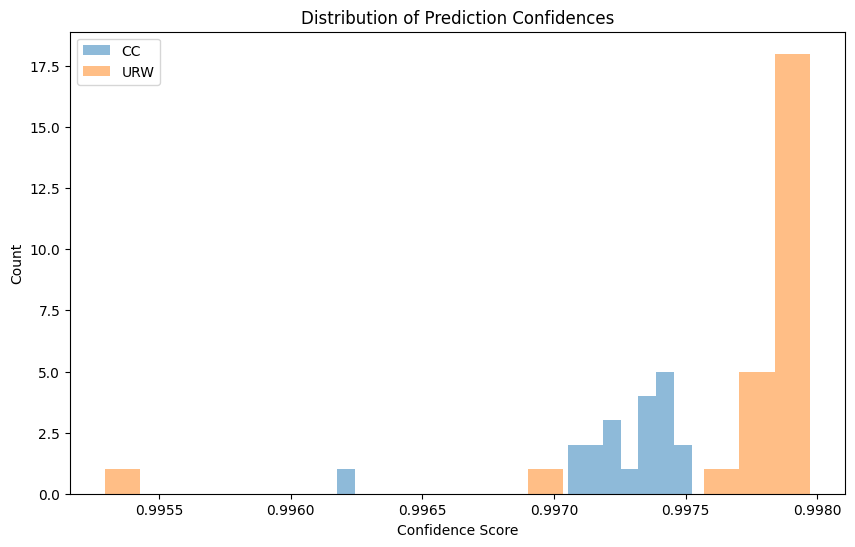

In [31]:
def plot_confidence_distribution():
    # Get confidences for test set
    cc_confidences = []
    urw_confidences = []

    for item in train_test['test']:
        result = classifier.predict(item['text'])
        if item['labels'] == 0:  # CC
            cc_confidences.append(result['confidence'])
        else:  # URW
            urw_confidences.append(result['confidence'])

    plt.figure(figsize=(10, 6))
    plt.hist(cc_confidences, alpha=0.5, label='CC', bins=20)
    plt.hist(urw_confidences, alpha=0.5, label='URW', bins=20)
    plt.title('Distribution of Prediction Confidences')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

plot_confidence_distribution()

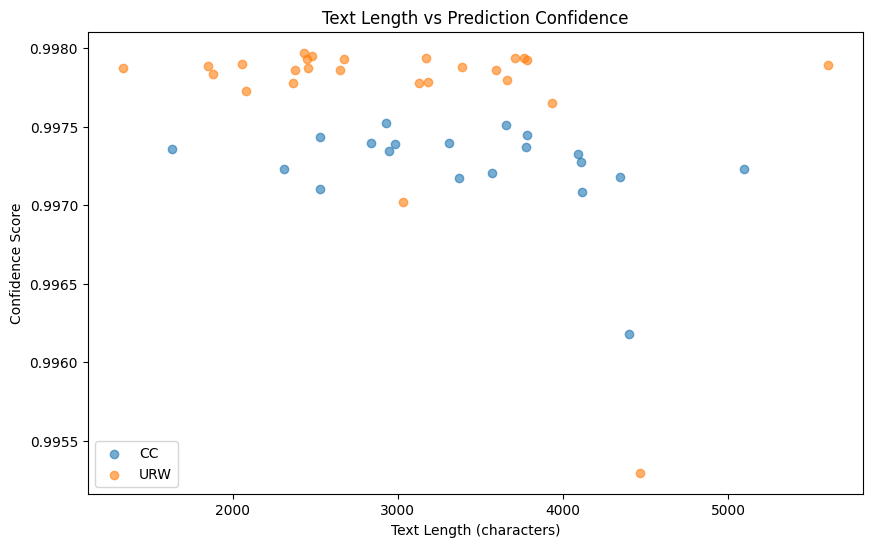

In [32]:
def plot_length_vs_confidence():
    lengths = []
    confidences = []
    categories = []

    for item in train_test['test']:
        result = classifier.predict(item['text'])
        lengths.append(len(item['text']))
        confidences.append(result['confidence'])
        categories.append('CC' if item['labels'] == 0 else 'URW')

    plt.figure(figsize=(10, 6))
    for category in ['CC', 'URW']:
        mask = [c == category for c in categories]
        plt.scatter(
            [l for l, m in zip(lengths, mask) if m],
            [c for c, m in zip(confidences, mask) if m],
            alpha=0.6,
            label=category
        )

    plt.title('Text Length vs Prediction Confidence')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Confidence Score')
    plt.legend()
    plt.show()

plot_length_vs_confidence()